Start with in-game stats dataset of 10754 players (not including goalkeepers) from 2022-2023 season.
After merging with player description dataset and preprocessing, drops to 7400 rows (unique players).
Then, keep only players that have played at least 8 games (1/4 of season).
Split dataset into 4, 1 for each position group.
Import 4 datasets regarding attackers, midfielders, defenders, and goalies.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

gk = pd.read_csv("2022_goalkeepers.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
best_goalies = ['Nick Pope', 'Emiliano Martínez', 'Aaron Ramsdale', 'Ederson', 'Gianluigi Donnarumma',
               'Jan Oblak', 'Mike Maignan', 'Alisson', 'Marc-André ter Stegen', 'Thibaut Courtois',
               'Yassine Bounou', 'Manuel Neuer', 'André Onana', 'Hugo Lloris', 'Unai Simón',
               'Yann Sommer', 'Wojciech Szczęsny', 'Gregor Kobel', 'Kevin Trapp', 'Álex Remiro',
               'Koen Casteels', 'Diogo Costa', 'Guglielmo Vicario', 'David Raya', 'Bernd Leno']

for index, row in gk.iterrows():
    if row['Player'] in best_goalies:
        gk.loc[index,'Success'] = 1
    else:
        gk.loc[index,'Success'] = 0

In [3]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

X = gk.drop('Success', axis=1)
y = gk['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_new = X_train.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 
                            'Nat', 'Based', 'Medium Cmp%', 'Short Cmp%', 'Long Cmp%'], axis=1)
X_train_new.columns = X_train_new.columns.str.strip()

X_test_new = X_test.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot",
                          'Nat', 'Based', 'Medium Cmp%', 'Short Cmp%', 'Long Cmp%'], axis=1)
X_test_new.columns = X_test_new.columns.str.strip()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import pandas as pd

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_new), columns=X_train_new.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_new), columns=X_test_new.columns)

# Define class weights
class_weights = {0: 1, 1: 21}

# Define the models
models = {
    'Logistic Regression - Newton': LogisticRegression(solver='newton-cg',penalty=None,max_iter=1000,class_weight=class_weights), 
    'Logistic Regression - lbgfs': LogisticRegression(solver='lbfgs',penalty=None,max_iter=5000,class_weight=class_weights), 
    'Logistic Regression - sag': LogisticRegression(solver='sag',penalty=None,max_iter=5000,class_weight=class_weights), 
    'Logistic Regression - saga': LogisticRegression(solver='saga',penalty=None,max_iter=3000,class_weight=class_weights),
    'Logistic Regression' : LogisticRegression(class_weight=class_weights),
    'SVM': SVC(kernel='linear',probability=True,class_weight=class_weights)
}

for model_name, model in models.items():

    model.fit(X_train_scaled, y_train)

    # Calculate AIC/BIC
    log_likelihood = np.sum(y_test * np.log(model.predict_proba(X_test_scaled)[:, 1]) + (1 - y_test) * np.log(1 - model.predict_proba(X_test_scaled)[:, 1]))
    num_params = len(model.coef_[0]) + 1
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(len(y_test))

    # Print AIC/BIC values
    print("\nAIC for " + model_name + ": " + str(aic))
    print("BIC for " + model_name + ": " + str(bic))


AIC for Logistic Regression - Newton: 134.67245366740448
BIC for Logistic Regression - Newton: 200.29900547930765

AIC for Logistic Regression - lbgfs: 134.68777671561617
BIC for Logistic Regression - lbgfs: 200.3143285275193


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



AIC for Logistic Regression - sag: 121.37332848637136
BIC for Logistic Regression - sag: 186.99988029827452

AIC for Logistic Regression - saga: 125.89918236228641
BIC for Logistic Regression - saga: 191.52573417418955

AIC for Logistic Regression: 127.05065879938269
BIC for Logistic Regression: 192.67721061128583

AIC for SVM: 96.74089487697782
BIC for SVM: 162.367446688881


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import shap

# Fit logistic regression model using scikit-learn
masker = shap.maskers.Independent(data = X_train_scaled)
model = SVC(kernel='linear',probability=True,class_weight=class_weights)
model.fit(X_train_scaled, y_train)
explainer = shap.LinearExplainer(model, masker=masker)
shap_values = explainer(X_test_scaled)

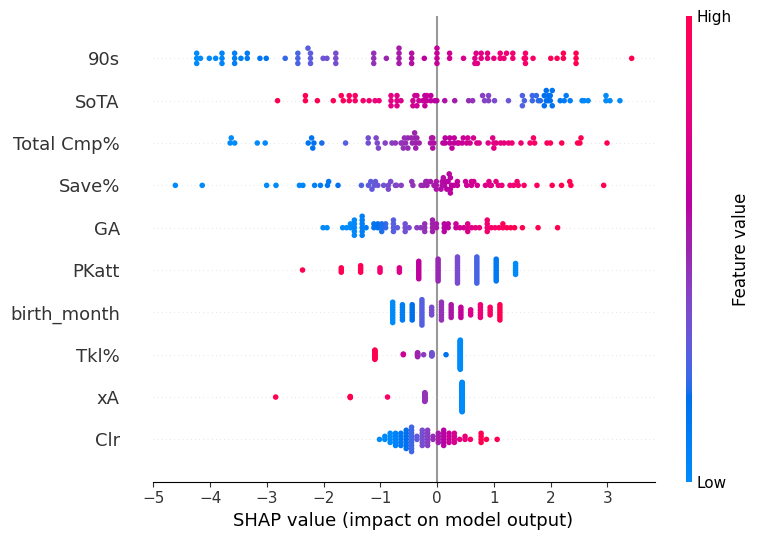

In [6]:
shap.summary_plot(shap_values, max_display=10, show=False)

import matplotlib.pyplot as pl
pl.savefig("shap_summary4.png",dpi=700)

In [7]:
X_test['predictions'] = model.predict(X_test_scaled)

In [8]:
X_test['predictions']

268    0.0
250    1.0
355    0.0
332    0.0
56     0.0
      ... 
104    1.0
167    0.0
63     0.0
233    0.0
84     0.0
Name: predictions, Length: 77, dtype: float64

In [9]:
df_scores_comp = pd.DataFrame({'Name':X_test['Player'], 'Actual':y_test, 'Predicted':X_test['predictions']})
df_scores_comp[df_scores_comp['Predicted']==1]

,Name,Actual,Predicted
250,Thomas Kaminski,0.0,1.0
114,Timon Wellenreuther,0.0,1.0
238,Vicente Guaita,0.0,1.0
110,Gregor Kobel,1.0,1.0
247,Danny Ward,0.0,1.0
39,Steve Clark,0.0,1.0
55,Federico Lanzillota,0.0,1.0
0,Nahuel Guzmán,0.0,1.0
300,Álex Remiro,1.0,1.0
108,Sinan Bolat,0.0,1.0


In [10]:
df_scores_comp[df_scores_comp['Actual']==1]

,Name,Actual,Predicted
110,Gregor Kobel,1.0,1.0
300,Álex Remiro,1.0,1.0
181,Mike Maignan,1.0,0.0
283,Unai Simón,1.0,0.0
231,Aaron Ramsdale,1.0,1.0
225,Alisson,1.0,1.0


<Axes: xlabel='PC1', ylabel='PC2'>

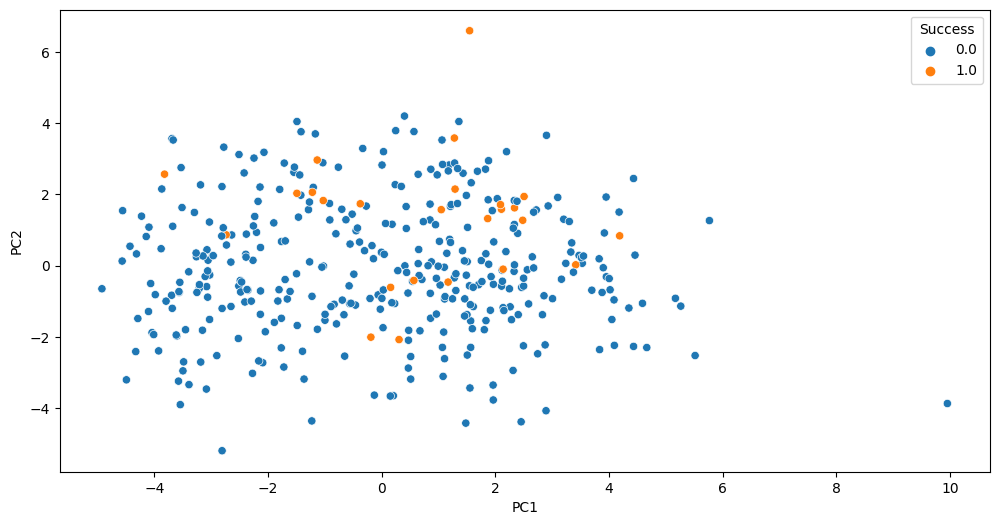

In [11]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt 

n_components = 2
X_new = X.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 'Nat', 'Based'], axis=1)

# Standardize the data
scaler = StandardScaler()
X_new = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

pca = PCA(n_components=n_components)
components = pca.fit_transform(X_new)

cumVar = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100, 
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(pca.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1).rename(index={0: "PC1", 1: "PC2"})

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
pcaDf = pd.concat([componentsDf, y], axis=1)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pcaDf, x="PC1", y="PC2", hue="Success")

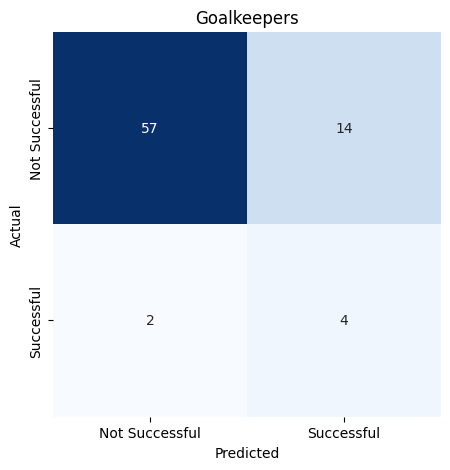

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.title('Goalkeepers')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision,3))

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,3))

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,3))

Accuracy: 0.792
Precision: 0.222
Recall: 0.667
F1-Score: 0.333
